In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import visutils
import matplotlib.patches as patches
from mpl_toolkits.mplot3d import Axes3D
import scipy.optimize
import cv2
from scipy.spatial import Delaunay
import math




%matplotlib notebook

In [2]:
def makerotation(rx,ry,rz):
    """
    Generate a rotation matrix    

    Parameters
    ----------
    rx,ry,rz : floats
        Amount to rotate around x, y and z axes in degrees

    Returns
    -------
    R : 2D numpy.array (dtype=float)
        Rotation matrix of shape (3,3)
    """
    Rx = np.array([[1,0,0],[0,np.cos(np.radians(rx)), -np.sin(np.radians(rx))],
                   [0,np.sin(np.radians(rx)), np.cos(np.radians(rx))]])
    Ry = np.array([[np.cos(np.radians(ry)),0,np.sin(np.radians(ry))],[0,1,0],
                   [-np.sin(np.radians(ry)),0,np.cos(np.radians(ry))]])
    Rz = np.array([[np.cos(np.radians(rz)), -np.sin(np.radians(rz)), 0],
                   [np.sin(np.radians(rz)), np.cos(np.radians(rz)), 0],[0, 0, 1]])
    
    return Rz@Ry@Rx

In [3]:
class Camera:
    """
    A simple data structure describing camera parameters 
    
    The parameters describing the camera
    cam.f : float   --- camera focal length (in units of pixels)
    cam.c : 2x1 vector  --- offset of principle point
    cam.R : 3x3 matrix --- camera rotation
    cam.t : 3x1 vector --- camera translation 
    
    """
    
    def __init__(self,f,c,R,t):
        self.f = f
        self.c = c
        self.R = R
        self.t = t

    def __str__(self):
        return f'Camera : \n f={self.f} \n c={self.c.T} \n R={self.R} \n t = {self.t.T}'
    
    def project(self,pts3):
        """
        Project the given 3D points in world coordinates into the specified camera    

        Parameters
        ----------
        pts3 : 2D numpy.array (dtype=float)
            Coordinates of N points stored in a array of shape (3,N)

        Returns
        -------
        pts2 : 2D numpy.array (dtype=float)
            Image coordinates of N points stored in an array of shape (2,N)

        """
        assert(pts3.shape[0]==3)

        focal = -np.array([[self.f,0,self.c[0]],[0,self.f,self.c[1]],[0,0,1]])
        temp = focal@np.linalg.inv(self.R)@(pts3-self.t)
        pts2 = temp[0:2]/temp[2]
        assert(pts2.shape[1]==pts3.shape[1])
        assert(pts2.shape[0]==2)
    
        return pts2
 
    def update_extrinsics(self,params):
        """
        Given a vector of extrinsic parameters, update the camera
        to use the provided parameters.
  
        Parameters
        ----------
        params : 1D numpy.array (dtype=float)
            Camera parameters we are optimizing over stored in a vector
            params[0:2] are the rotation angles, params[2:5] are the translation

       """ 
        self.R = makerotation(params[0],params[1],params[2])
        self.t = np.array([[params[3]],[params[4]],[params[5]]])

In [4]:
def residuals(pts3,pts2,cam,params):
    """
    Compute the difference between the projection of 3D points by the camera
    with the given parameters and the observed 2D locations

    Parameters
    ----------
    pts3 : 2D numpy.array (dtype=float)
        Coordinates of N points stored in a array of shape (3,N)

    pts2 : 2D numpy.array (dtype=float)
        Coordinates of N points stored in a array of shape (2,N)

    params : 1D numpy.array (dtype=float)
        Camera parameters we are optimizing stored in a vector of shape (6)

    Returns
    -------
    residual : 1D numpy.array (dtype=float)
        Vector of residual 2D projection errors of size 2*N
        
    """
    cam.update_extrinsics(params)
    result = pts2-cam.project(pts3)
    return result.flatten()

In [5]:
def triangulate(pts2L, pts2R, camL, camR):
    
    assert(len(pts2L) == 2 and len(pts2R) == 2)
    assert(len(pts2L[0]) == len(pts2R[0]))
    
    npts = len(pts2L[0])
    Lmat, Lrv, lL = camL[:]
    Rmat, Rrv, rL = camR[:]
    Rtrl = (-cv2.Rodrigues(Rrv)[0]).dot(rL)
    Ltrl = (-cv2.Rodrigues(Lrv)[0]).dot(lL)
    
    qL = np.ones((3,npts), np.float32)
    qL[0,:] = (pts2L[0,:] - Lmat[0,2]) / Lmat[0,0] 
    qL[1,:] = (pts2L[1,:] - Lmat[1,2]) / Lmat[1,1] 
    qR = np.ones((3,npts), np.float32)
    qR[0,:] = (pts2R[0,:] - Rmat[0,2]) / Rmat[0,0] 
    qR[1,:] = (pts2R[1,:] - Rmat[1,2]) / Rmat[1,1] 

    Rt = np.matmul(np.linalg.inv(cv2.Rodrigues(Lrv)[0]), cv2.Rodrigues(Rrv)[0])
    tl = np.matmul(np.linalg.inv(cv2.Rodrigues(Lrv)[0]), (Rtrl - Ltrl))
    
    XL = np.zeros((3, npts))
    XR = np.zeros((3, npts))
    for i in range(0, npts):
        front = np.array([qL[:,i]]).transpose()
        qR_transposed = np.array([qR[:,i]]).transpose()
        A = np.hstack((front, np.matmul(-Rt, qR_transposed) ))
        Z = np.linalg.lstsq(A,tl, rcond=None)[0]
        
        XL[:,i] = qL[:,i]*Z[0]
        XR[:,i] = qR[:,i]*Z[1]
        
    Xa = np.zeros((3, npts))
    Xb = np.zeros((3, npts))
    Xa = cv2.Rodrigues(Lrv)[0].dot(XL) + Ltrl
    Xb = cv2.Rodrigues(Rrv)[0].dot(XR) + Rtrl
      
    X = 0.5*(Xa+Xb)
    
    return X

In [53]:
calibSquareWidth = 27.75
chessboardSize= (8,6)

# generate object points
objp = np.zeros((6*8,3), np.float32)
objp[:,:2] = 2.8*np.mgrid[0:8, 0:6].T.reshape(-1,2)

# corner refinement termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.0001)


def calibrate(imageprefix, suffix, start, stop):
    imgPoints = []
    objPoints = []
    
    objPts = np.zeros((8*6, 3), np.float32)
    objPts[:,:2] = np.mgrid[0:8, 0:6].T.reshape(-1,2)
    objPts[:,1] = objPts[:,1] * -1;
    objPts = objPts*calibSquareWidth

    
    for frame in range(start,stop+1):
        if frame == 14 or frame == 16:
            continue    
        filename = "%s%02d%s" % (imageprefix, frame, suffix)
        img = cv2.imread(filename)
        img_size = (img.shape[1], img.shape[0])
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (8,6), None)
        if ret == True:
            gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
            corners = cv2.cornerSubPix(gray, corners, (11,11), (-1,-1), criteria)
            objPoints.append(objPts)
            imgPoints.append(corners)
            img = cv2.drawChessboardCorners(img,chessboardSize, corners, ret)
            cv2.imshow('img',img)
            cv2.waitKey(200)
    
    objPoints = np.array(objPoints)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objPoints, imgPoints, img.shape[:-1], None, None)
    return (mtx, rvecs, tvecs, dist)

def run_calibrate():
    c0_prefix = "/Users/michael.qi_chen/Desktop/CS 117/calib_jpg_u/frame_C0_"
    c1_prefix = "/Users/michael.qi_chen/Desktop/CS 117/calib_jpg_u/frame_C1_"
    suffix = ".jpg"

    C0_calib = calibrate(c0_prefix, suffix, 1, 21)
    C1_calib = calibrate(c1_prefix, suffix, 1, 21)
    with open('/Users/michael.qi_chen/Desktop/CS 117/calib_jpg_u/C0_CALIB.pkl', 'wb') as c0:
        pickle.dump(C0_calib, c0)     
    with open('/Users/michael.qi_chen/Desktop/CS 117/calib_jpg_u/C1_CALIB.pkl', 'wb') as c1:
        pickle.dump(C1_calib, c1)
    print('done')
    return None
    

run_calibrate()

done


In [18]:
def decode(imageprefix, start, stop, threshold):
    bit = 0
    H, W = 0, 0
    gp = [];
    G = []
    for i in range(start, stop, 2):
        I1_name = "%s%02d.png" % (imageprefix, i)
        I2_name = "%s%02d.png" % (imageprefix, (i+1))
        img1 = ( cv2.imread(I1_name, cv2.IMREAD_GRAYSCALE) )
        img2 = ( cv2.imread(I2_name, cv2.IMREAD_GRAYSCALE) )
        i1 = np.iinfo(img1.dtype)
        i2 = np.iinfo(img2.dtype)
        I1 = img1.astype(np.float) / i1.max
        I2 = img2.astype(np.float) / i2.max
        if i == start:
            print(I1_name)
            H = np.shape(I1)[0]
            W = np.shape(I1)[1]
            gp = np.ones((H,W))
        G.append( I1 > I2 )
        gp = np.logical_and(gp, cv2.absdiff(I1,I2) > threshold)
        bit += 1
    BCD = [G[0]]
    for i in range(1,bit):
        BCD.append( np.bitwise_xor(BCD[i-1], G[i]) )
    C = np.zeros((H, W))
    for p in range(1,bit+1):
        C = C + BCD[p-1]*(pow(2,(10-p)))
    return (C, gp)


/Users/michael.qi_chen/Desktop/CS 117/teapot/grab_0_u/frame_C0_00.png


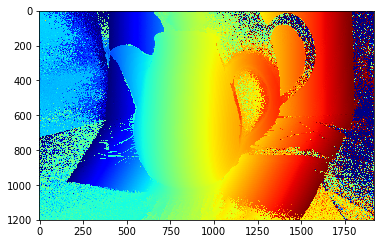

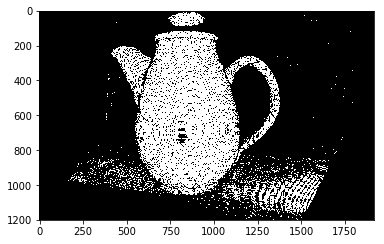

In [34]:
thresh = 0.02
RH,RH_good = decode("/Users/michael.qi_chen/Desktop/CS 117/teapot/grab_0_u/frame_C0_",0,19,thresh)
plt.figure("code")
plt.imshow(RH,cmap=plt.cm.jet)
plt.figure("mask")
plt.imshow(RH_good,cmap=plt.cm.gray)

plt.show()

In [56]:

def reconstruct(scandir, thresh = 0.015):
    
    def _intersect_matlab(a, b):
        a1, ia = np.unique(a, return_index=True)
        b1, ib = np.unique(b, return_index=True)
        aux = np.concatenate((a1, b1))
        aux.sort()
        c = aux[:-1][aux[1:] == aux[:-1]]
        return c, ia[np.isin(a1, c)], ib[np.isin(b1, c)]
    
    with open("/Users/michael.qi_chen/desktop/CS 117/calib_jpg_u/C0_CALIB.pkl", "rb") as c0: 
        R_mat, R_rvec, R_tvec, R_dist = pickle.load(c0)
        
    with open("/Users/michael.qi_chen/desktop/CS 117/calib_jpg_u/C1_CALIB.pkl", "rb") as c1: 
        L_mat, L_rvec, L_tvec, L_dist = pickle.load(c1)    
    
    R_h,R_h_good = decode(scandir+'frame_C0_', 0, 19, thresh)
    R_v,R_v_good = decode(scandir+'frame_C0_', 20, 39, thresh)
    L_h,L_h_good = decode(scandir+'frame_C1_', 0, 19, thresh)
    L_v,L_v_good = decode(scandir+'frame_C1_', 20, 39, thresh)
    
    assert(np.shape(R_h) == np.shape(L_v))
    H, W = np.shape(R_h)
    
    L_h_shifted = np.left_shift(L_h.astype(int), 10)
    R_h_shifted = np.left_shift(R_h.astype(int), 10)
    L_C = np.bitwise_or(L_h_shifted, L_v.astype(int))
    R_C = np.bitwise_or(R_h_shifted, R_v.astype(int))
    
    L_good = np.logical_and(L_v_good, L_h_good)
    R_good = np.logical_and(R_v_good, R_h_good)

    R_color = ( cv2.imread(scandir+'color_C0_01.png', cv2.IMREAD_COLOR) )
    R_background = ( cv2.imread(scandir+'color_C0_00.png', cv2.IMREAD_COLOR) )
    L_color = ( cv2.imread(scandir+'color_C1_01.png', cv2.IMREAD_COLOR) )
    L_background = ( cv2.imread(scandir+'color_C1_00.png', cv2.IMREAD_COLOR) )
    i1 = np.iinfo(R_color.dtype)
    i2 = np.iinfo(R_background.dtype)
    i3 = np.iinfo(L_color.dtype)
    i4 = np.iinfo(L_background.dtype)
    R_color = R_color.astype(np.float) / i1.max
    R_background = R_background.astype(np.float) / i2.max
    L_color = L_color.astype(np.float) / i3.max
    L_background = L_background.astype(np.float) / i4.max
    R_colormap = abs(R_color-R_background)**2 > thresh
    L_colormap = abs(L_color-L_background)**2 > thresh
    
    R_ok = np.logical_or(R_colormap[:,:,0], R_colormap[:,:,1])
    R_ok = np.logical_or(R_colormap[:,:,2], R_ok)
    L_ok = np.logical_or(L_colormap[:,:,0], L_colormap[:,:,1])
    L_ok = np.logical_or(L_colormap[:,:,2], L_ok)
    R_good = np.logical_and(R_ok, R_good)
    L_good = np.logical_and(L_ok, L_good)
    
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,20))
    ax1.imshow(L_C*L_good, cmap = 'jet')
    ax1.set_title('Left')
    ax2.imshow(R_C*R_good, cmap = 'jet')
    ax2.set_title('Right')
    plt.show()
    
    assert(np.shape(R_good) == (H,W))
    ret = [[],[]]
    for i in range(H):
        for j in range(W):
            if R_good[i][j]:
                ret[0].append(j)
                ret[1].append(i) 
    R_coord = np.array(ret)
    assert(np.shape(L_good) == (H,W))
    ret = [[],[]]
    for i in range(H):
        for j in range(W):
            if L_good[i][j]:
                ret[0].append(j)
                ret[1].append(i) 
    L_coord = np.array(ret)
    R_C_good = R_C[R_good]
    L_C_good = L_C[L_good]
    a1, ia = np.unique(R_C_good, return_index=True)
    b1, ib = np.unique(L_C_good, return_index=True)
    aux = np.concatenate((a1, b1))
    aux.sort()
    c = aux[:-1][aux[1:] == aux[:-1]]
    matched, iR, iL = c, ia[np.isin(a1, c)], ib[np.isin(b1, c)]
    xR = R_coord[:,iR]
    xL = L_coord[:,iL]
    camL = (L_mat, L_rvec[2], L_tvec[2])
    camR = (R_mat, R_rvec[2], R_tvec[2])
    
    #print(camL)
    #print(camR)
    
    X = triangulate(xL, xR, camL, camR)
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.scatter(X[0,:], X[1,:], X[2,:])
    ax.view_init(45,0)
    
    ax.set_xlabel('x axis')
    ax.set_ylabel('y axis')
    ax.set_zlabel('z axis')
    plt.show()
    return [X, xL, xR, L_color, R_color]

In [57]:
def mesh(num ,scandir,thresh,limit,tri_pru):
    x_up_limit,x_low_limit,y_up_limit,y_low_limit,z_up_limit,z_low_limit = limit[0] , limit[1],limit[2],limit[3],limit[4],limit[5]   
    X, xL, xR, L_color, R_color = reconstruct(scandir, thresh)
    npts = np.shape(X)[1]
    goodidx = []
    for i in range(npts):
        x_ok = X[0,i] < x_up_limit and X[0,i] > x_low_limit
        y_ok = X[1,i] < y_up_limit and X[1,i] > y_low_limit
        z_ok = X[2,i] < z_up_limit and X[2,i] > z_low_limit
        if x_ok and y_ok and z_ok:
            goodidx.append(i)
    assert(len(goodidx) >= 3)
    X = X[:,goodidx]
    xL = xL[:,goodidx]
    xR = xR[:,goodidx]
    tri = Delaunay(xR.transpose())
    tridx = tri.simplices
    goodtri = []
    k = 0
    for i in range(np.shape(tridx)[0]):
        AB = math.sqrt((X[:,tridx[i,0]][0]-X[:,tridx[i,1]][0])**2 + (X[:,tridx[i,0]][1]-X[:,tridx[i,1]][1])**2 + (X[:,tridx[i,0]][2]-X[:,tridx[i,1]][2])**2)
        BC = math.sqrt((X[:,tridx[i,1]][0]-X[:,tridx[i,2]][0])**2 + (X[:,tridx[i,1]][1]-X[:,tridx[i,2]][1])**2 + (X[:,tridx[i,1]][2]-X[:,tridx[i,2]][2])**2)
        AC = math.sqrt((X[:,tridx[i,0]][0]-X[:,tridx[i,2]][0])**2 + (X[:,tridx[i,0]][1]-X[:,tridx[i,2]][1])**2 + (X[:,tridx[i,0]][2]-X[:,tridx[i,2]][2])**2)
        if max([AB,BC,AC]) < tri_pru:
            k = k+1
            goodtri.append(i)
    
    goodtri = goodtri[:k]
    tridx = tridx[goodtri,:]
    ptind = np.unique(np.reshape(tridx, (1,-1)))
    X = X[:,ptind]
    xR = xR[:,ptind]
    xL = xL[:,ptind]
    idxmap = dict()
    for i,j in enumerate(ptind):
        idxmap[j] = i
    for i in range(np.shape(tridx)[0]):
        for j in range(np.shape(tridx)[1]):
            tridx[i,j] = idxmap[tridx[i,j]]
        
    colorCount = np.shape(X)[1]
    xColor = np.zeros((3,colorCount))
    for i in range(colorCount):
        rx, ry = xR[:,i]
        lx, ly = xL[:,i]
        xColor[2,i] = 0.5*(R_color[ry,rx,0] + L_color[ly,lx,0]) #B
        xColor[1,i] = 0.5*(R_color[ry,rx,1] + L_color[ly,lx,1]) #G
        xColor[0,i] = 0.5*(R_color[ry,rx,2] + L_color[ly,lx,2]) #R
    trimsh = np.zeros(np.shape(tridx))
    for i in range(np.shape(tridx)[0]):
        trimsh[i,0] = tridx[i,0]
        trimsh[i,1] = tridx[i,1]
        trimsh[i,2] = tridx[i,2]
        
    rf = "grab_%d_u" % num +".pickle"
    result = [X, xColor,tridx.astype(float),trimsh.astype(float),scandir,num]
    fid = open(rf, "wb" ) 
    pickle.dump(result,fid)
    fid.close()


    return 0



/Users/michael.qi_chen/desktop/CS 117/teapot/grab_0_u/frame_C0_00.png
/Users/michael.qi_chen/desktop/CS 117/teapot/grab_0_u/frame_C0_20.png
/Users/michael.qi_chen/desktop/CS 117/teapot/grab_0_u/frame_C1_00.png
/Users/michael.qi_chen/desktop/CS 117/teapot/grab_0_u/frame_C1_20.png


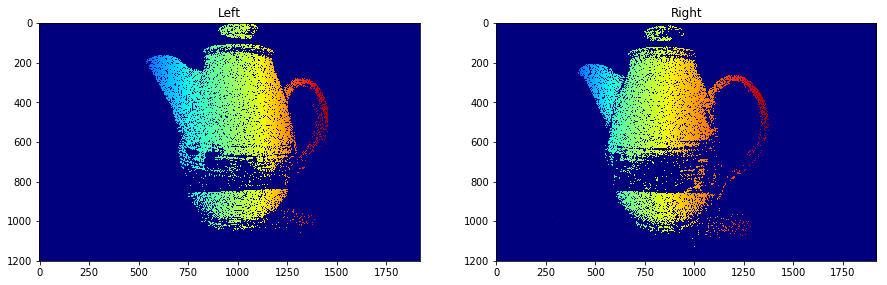

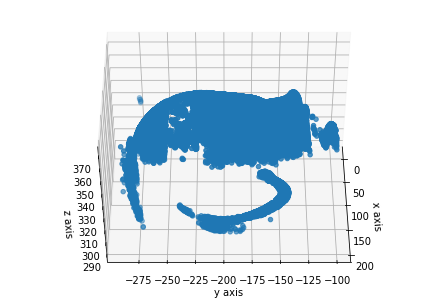

/Users/michael.qi_chen/desktop/CS 117/teapot/grab_1_u/frame_C0_00.png
/Users/michael.qi_chen/desktop/CS 117/teapot/grab_1_u/frame_C0_20.png
/Users/michael.qi_chen/desktop/CS 117/teapot/grab_1_u/frame_C1_00.png
/Users/michael.qi_chen/desktop/CS 117/teapot/grab_1_u/frame_C1_20.png


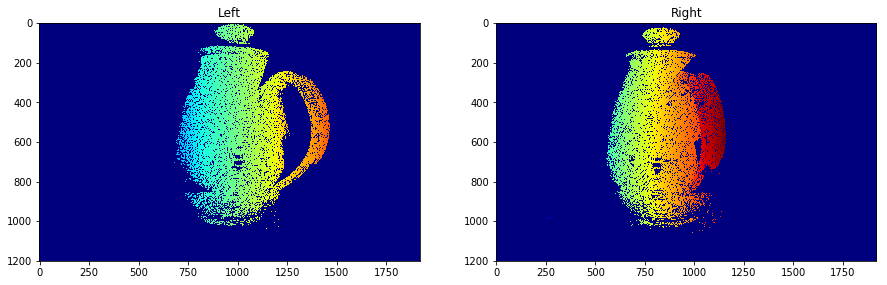

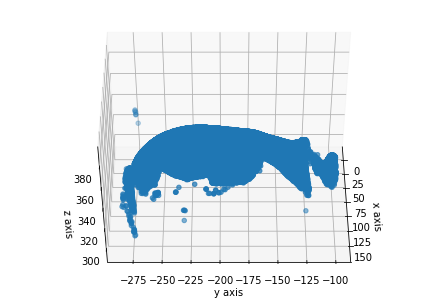

/Users/michael.qi_chen/desktop/CS 117/teapot/grab_2_u/frame_C0_00.png
/Users/michael.qi_chen/desktop/CS 117/teapot/grab_2_u/frame_C0_20.png
/Users/michael.qi_chen/desktop/CS 117/teapot/grab_2_u/frame_C1_00.png
/Users/michael.qi_chen/desktop/CS 117/teapot/grab_2_u/frame_C1_20.png


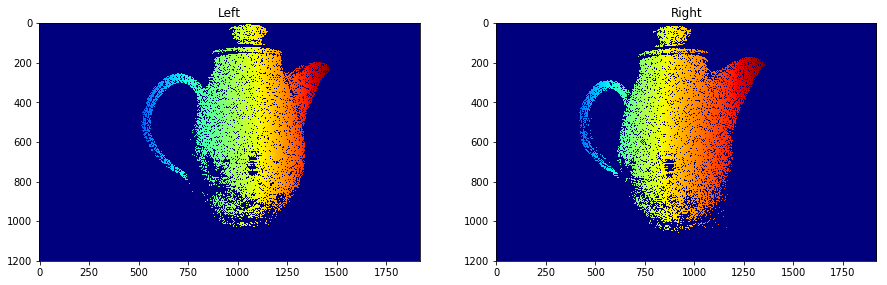

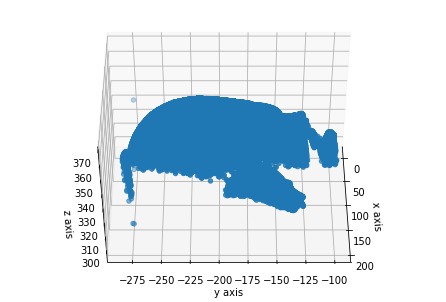

/Users/michael.qi_chen/desktop/CS 117/teapot/grab_3_u/frame_C0_00.png
/Users/michael.qi_chen/desktop/CS 117/teapot/grab_3_u/frame_C0_20.png
/Users/michael.qi_chen/desktop/CS 117/teapot/grab_3_u/frame_C1_00.png
/Users/michael.qi_chen/desktop/CS 117/teapot/grab_3_u/frame_C1_20.png


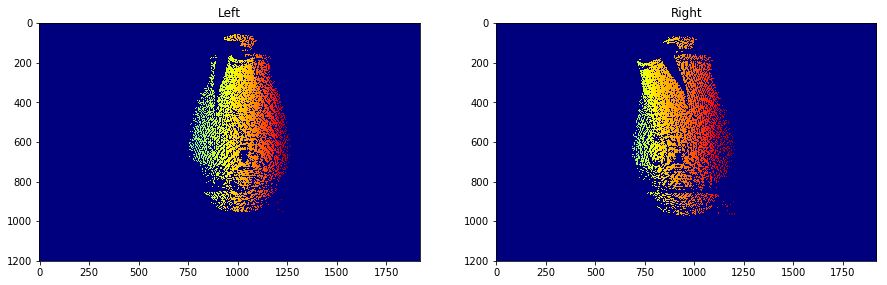

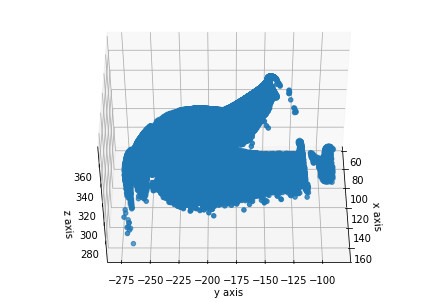

/Users/michael.qi_chen/desktop/CS 117/teapot/grab_4_u/frame_C0_00.png
/Users/michael.qi_chen/desktop/CS 117/teapot/grab_4_u/frame_C0_20.png
/Users/michael.qi_chen/desktop/CS 117/teapot/grab_4_u/frame_C1_00.png
/Users/michael.qi_chen/desktop/CS 117/teapot/grab_4_u/frame_C1_20.png


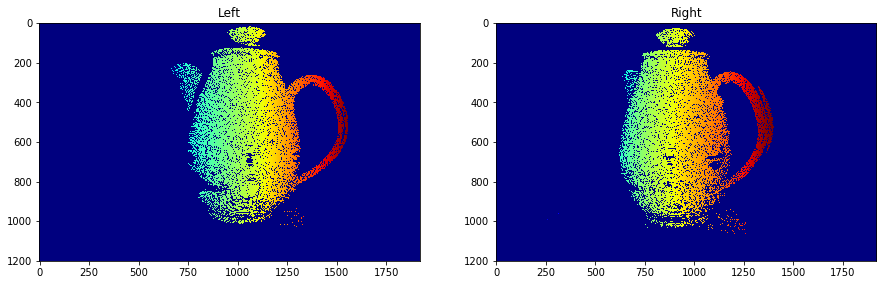

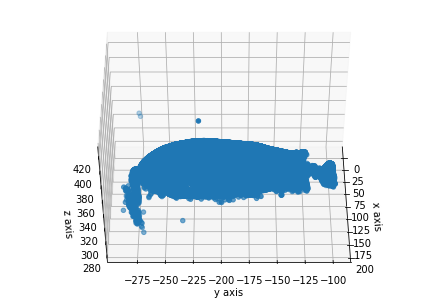

/Users/michael.qi_chen/desktop/CS 117/teapot/grab_5_u/frame_C0_00.png
/Users/michael.qi_chen/desktop/CS 117/teapot/grab_5_u/frame_C0_20.png
/Users/michael.qi_chen/desktop/CS 117/teapot/grab_5_u/frame_C1_00.png
/Users/michael.qi_chen/desktop/CS 117/teapot/grab_5_u/frame_C1_20.png


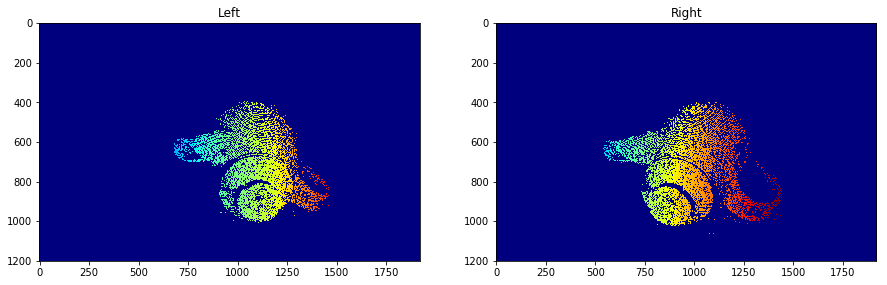

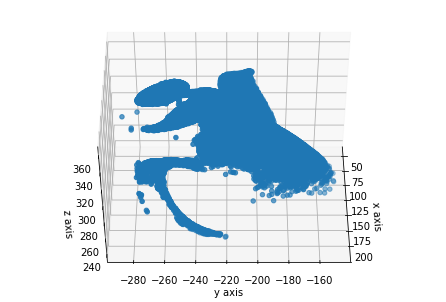

/Users/michael.qi_chen/desktop/CS 117/teapot/grab_6_u/frame_C0_00.png
/Users/michael.qi_chen/desktop/CS 117/teapot/grab_6_u/frame_C0_20.png
/Users/michael.qi_chen/desktop/CS 117/teapot/grab_6_u/frame_C1_00.png
/Users/michael.qi_chen/desktop/CS 117/teapot/grab_6_u/frame_C1_20.png


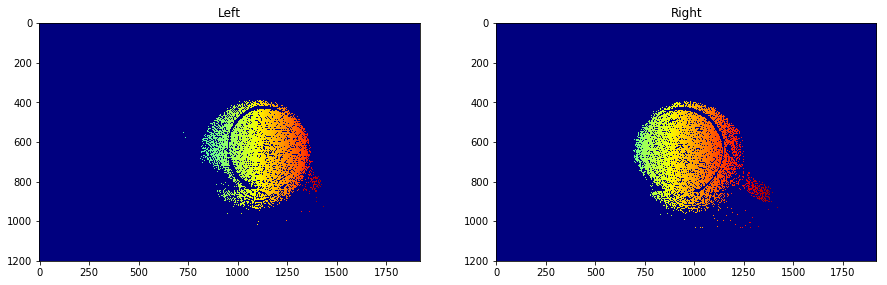

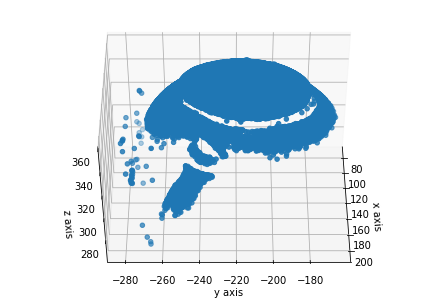

In [58]:
thresh1 = 0.015
limit = [250, 0, 0, -270, 400, 200]
tri_pru = 10 

for i in range(7):
    scandir = "/Users/michael.qi_chen/desktop/CS 117/teapot/grab_%d_u/"% i
    mesh(i,scandir,thresh1,limit,tri_pru)

In [50]:
def writeply(X,color,tri,filename):
    """
    Save out a triangulated mesh to a ply file
    
    Parameters
    ----------
    pts3 : 2D numpy.array (dtype=float)
        vertex coordinates shape (3,Nvert)
        
    color : 2D numpy.array (dtype=float)
        vertex colors shape (3,Nvert)
        should be float in range (0..1)
        
    tri : 2D numpy.array (dtype=float)
        triangular faces shape (Ntri,3)
        
    filename : string
        filename to save to    
    """
    f = open(filename,"w");
    f.write('ply\n');
    f.write('format ascii 1.0\n');
    f.write('element vertex %i\n' % X.shape[1]);
    f.write('property float x\n');
    f.write('property float y\n');
    f.write('property float z\n');
    f.write('property uchar red\n');
    f.write('property uchar green\n');
    f.write('property uchar blue\n');
    f.write('element face %d\n' % tri.shape[0]);
    f.write('property list uchar int vertex_indices\n');
    f.write('end_header\n');

    C = (255*color).astype('uint8')
    
    for i in range(X.shape[1]):
        f.write('%f %f %f %i %i %i\n' % (X[0,i],X[1,i],X[2,i],C[0,i],C[1,i],C[2,i]));
    
    for t in range(tri.shape[0]):
        f.write('3 %d %d %d\n' % (tri[t,1],tri[t,0],tri[t,2]))

    f.close();




In [51]:
for i in range(7):
    path= "/Users/michael.qi_chen/Desktop/cs 117/grab_%d_u.pickle" % i
    filename = "mesh_to_ply%d.ply"%i
    pickle_in = open(path,"rb")
    
    X, xColor,tridx,trimsh,scandir,grab = pickle.load(pickle_in)
    pickle_in.close
    writeply(X,xColor,trimsh,filename)
    